In [1]:
import numpy as np
import matplotlib.pyplot as plt

import nn_framework as nnf

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from PIL import Image

## Датасет AUTO MPG

#### решим задачу регрессии

In [2]:
auto_mpg = fetch_openml(name='autoMpg', version=1, as_frame=True)
df = auto_mpg.frame.copy()

In [3]:
df.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model', 'origin', 'class'],
      dtype='object')

In [4]:
df = df.dropna()
df.rename(columns={'class': 'mpg'}, inplace=True)

y = df['mpg'].to_numpy() 
df = df.drop(columns=['mpg'])
X = df.to_numpy()

print("dataset shape:", X.shape, y.shape)

dataset shape: (392, 7) (392,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

train_dataset = nnf.Dataset(X_train_scaled, y_train.reshape(-1, 1))
test_dataset  = nnf.Dataset(X_test_scaled,  y_test.reshape(-1, 1))

print("train size:", len(train_dataset))
print("test size: ", len(test_dataset))

train size: 313
test size:  79


In [7]:
model_reg = nnf.Sequential(layers=[
    nnf.Dense(input_dim=7, output_dim=32),
    nnf.Activation(nnf.tanh, nnf.tanh_prime),

    nnf.Dense(input_dim=32, output_dim=16),
    nnf.Activation(nnf.tanh, nnf.tanh_prime),

    nnf.Dense(input_dim=16, output_dim=1)
], loss=nnf.MSE())

In [8]:
optimizer = nnf.MomentumSGD(lr=0.01, momentum=0.9)

epochs = 2000
batch_size = 32
loss_history = []

for epoch in range(epochs):
    train_dataset.shuffle()
    batch_losses = []

    for X_batch, y_batch in train_dataset.batch(batch_size):
        y_pred = model_reg.forward(X_batch)

        loss, grad = model_reg.compute_loss_and_grad(y_pred, y_batch)
        batch_losses.append(loss)
        model_reg.backward(grad)
        optimizer.step(model_reg)

    epoch_loss = np.mean(batch_losses)
    loss_history.append(epoch_loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 50/2000, Loss: 4.8124
Epoch 100/2000, Loss: 4.2182
Epoch 150/2000, Loss: 3.2476
Epoch 200/2000, Loss: 3.2352
Epoch 250/2000, Loss: 3.0025
Epoch 300/2000, Loss: 2.7829
Epoch 350/2000, Loss: 3.2985
Epoch 400/2000, Loss: 2.6538
Epoch 450/2000, Loss: 2.6930
Epoch 500/2000, Loss: 2.8783
Epoch 550/2000, Loss: 2.6147
Epoch 600/2000, Loss: 2.3686
Epoch 650/2000, Loss: 2.2862
Epoch 700/2000, Loss: 2.2939
Epoch 750/2000, Loss: 2.2414
Epoch 800/2000, Loss: 2.3100
Epoch 850/2000, Loss: 3.0865
Epoch 900/2000, Loss: 2.5721
Epoch 950/2000, Loss: 2.4612
Epoch 1000/2000, Loss: 2.3475
Epoch 1050/2000, Loss: 2.3519
Epoch 1100/2000, Loss: 2.4385
Epoch 1150/2000, Loss: 2.3503
Epoch 1200/2000, Loss: 2.2313
Epoch 1250/2000, Loss: 2.2347
Epoch 1300/2000, Loss: 2.3598
Epoch 1350/2000, Loss: 2.1215
Epoch 1400/2000, Loss: 2.1491
Epoch 1450/2000, Loss: 1.9837
Epoch 1500/2000, Loss: 1.9302
Epoch 1550/2000, Loss: 1.8693
Epoch 1600/2000, Loss: 1.9551
Epoch 1650/2000, Loss: 2.0331
Epoch 1700/2000, Loss: 1.9877


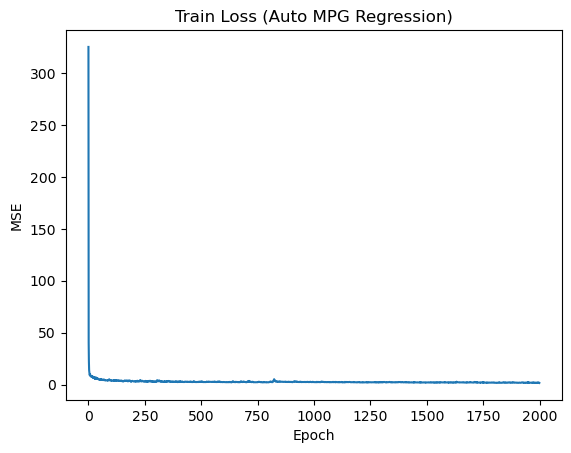

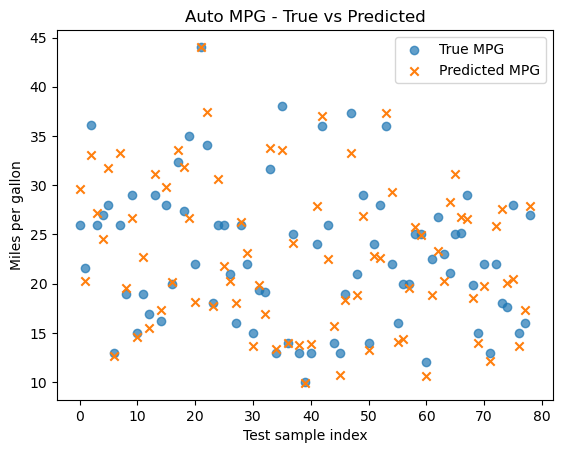

In [ ]:
plt.figure()
plt.plot(loss_history)
plt.title("Train Loss (Auto MPG Regression)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

y_pred_test = model_reg.predict(X_test_scaled)

plt.figure()
plt.scatter(range(len(y_test)), y_test, label="True MPG", alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_test, label="Predicted MPG", marker='x')
plt.title("Auto MPG - True vs Predicted")
plt.xlabel("Test sample index")
plt.ylabel("Miles per gallon")
plt.legend()
plt.show()

In [10]:
# MSE, RMSE, R^2
mse_test = nnf.compute_MSE(y_pred_test, y_test)
rmse_test = nnf.compute_RMSE(mse_test)
r2_test = nnf.compute_R2(y_test, y_pred_test)
print("test MSE:", mse_test)
print("test RMSE:", rmse_test)
print("test R2 Score:", r2_test)


test MSE: 10.432817270346758
test RMSE: 3.2299871935267417
test R2 Score: 0.7955976086456986


## Датасет MNIST

#### решим задачу классификации

In [11]:
train_dataset_mnist = nnf.get_mnist_dataset(train=True)
test_dataset_mnist  = nnf.get_mnist_dataset(train=False)

print("train dataset size:", len(train_dataset_mnist))
print("test dataset size: ", len(test_dataset_mnist))

train dataset size: 60000
test dataset size:  10000


In [12]:
model = nnf.Sequential(
    layers=[
        nnf.Dense(input_dim=784, output_dim=256),
        nnf.Activation(nnf.relu, nnf.relu_prime),
        nnf.Dense(input_dim=256, output_dim=128),
        nnf.Activation(nnf.relu, nnf.relu_prime),
        nnf.Dense(input_dim=128, output_dim=10)
    ],
    loss=nnf.CrossEntropy()
)

In [13]:
def compute_accuracy(model: nnf.Sequential, dataset: nnf.Dataset, batch_size: int = 128) -> float:
    correct = 0
    total = 0
    for X_batch, y_batch in dataset.batch(batch_size):
        logits = model.forward(X_batch)
        preds = np.argmax(logits, axis=1)
        correct += np.sum(preds == y_batch)
        total += len(y_batch)
    return correct / total

In [14]:
optimizer = nnf.MomentumSGD(lr=0.01, momentum=0.9)

epochs = 20 
batch_size = 64

train_loss_history = []
train_acc_history  = []
test_acc_history   = []

for epoch in range(epochs):
    train_dataset_mnist.shuffle()

    batch_losses = []

    for X_batch, y_batch in train_dataset_mnist.batch(batch_size):
        logits = model.forward(X_batch)
        loss_value, grad = model.compute_loss_and_grad(logits, y_batch)
        batch_losses.append(loss_value)
        model.backward(grad)
        optimizer.step(model)

    epoch_loss = np.mean(batch_losses)
    train_loss_history.append(epoch_loss)

    train_acc = compute_accuracy(model, train_dataset_mnist, batch_size=512)
    test_acc  = compute_accuracy(model, test_dataset_mnist,  batch_size=512)

    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

final_test_acc = compute_accuracy(model, test_dataset_mnist, batch_size=512)
print(f"Final test accuracy: {final_test_acc * 100:.2f}%")

Epoch 1/20 | Loss: 0.3051 | Train Acc: 0.9641 | Test Acc: 0.9603
Epoch 2/20 | Loss: 0.1055 | Train Acc: 0.9768 | Test Acc: 0.9716
Epoch 3/20 | Loss: 0.0688 | Train Acc: 0.9843 | Test Acc: 0.9719
Epoch 4/20 | Loss: 0.0502 | Train Acc: 0.9880 | Test Acc: 0.9760
Epoch 5/20 | Loss: 0.0371 | Train Acc: 0.9925 | Test Acc: 0.9791
Epoch 6/20 | Loss: 0.0276 | Train Acc: 0.9947 | Test Acc: 0.9800
Epoch 7/20 | Loss: 0.0176 | Train Acc: 0.9959 | Test Acc: 0.9800
Epoch 8/20 | Loss: 0.0148 | Train Acc: 0.9965 | Test Acc: 0.9796
Epoch 9/20 | Loss: 0.0111 | Train Acc: 0.9987 | Test Acc: 0.9832
Epoch 10/20 | Loss: 0.0066 | Train Acc: 0.9993 | Test Acc: 0.9828
Epoch 11/20 | Loss: 0.0042 | Train Acc: 0.9994 | Test Acc: 0.9824
Epoch 12/20 | Loss: 0.0027 | Train Acc: 0.9997 | Test Acc: 0.9824
Epoch 13/20 | Loss: 0.0019 | Train Acc: 0.9999 | Test Acc: 0.9832
Epoch 14/20 | Loss: 0.0011 | Train Acc: 1.0000 | Test Acc: 0.9838
Epoch 15/20 | Loss: 0.0008 | Train Acc: 1.0000 | Test Acc: 0.9838
Epoch 16/20 | Loss:

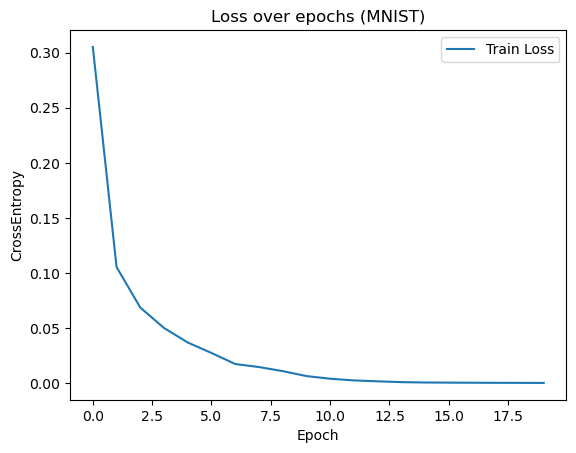

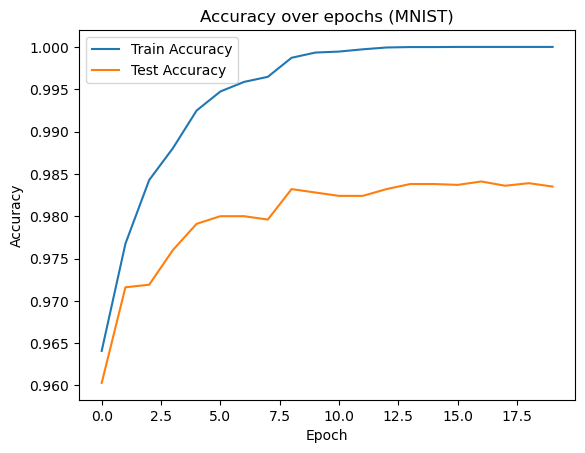

In [15]:
plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.title("Loss over epochs (MNIST)")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.title("Accuracy over epochs (MNIST)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Выполним инференс на данные из директории digits

In [16]:
dir_path = "./digits/"

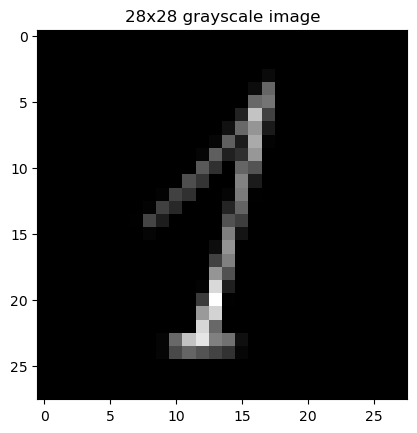

In [17]:
img_path = f"{dir_path}black_1.jpg"

img = Image.open(img_path)
img = img.convert('L').resize((28, 28))
plt.imshow(img, cmap='gray')
plt.title("28x28 grayscale image")
plt.show()

In [18]:
img_np = np.array(img)
img_np = img_np / 255.0
sample = img_np.reshape(1, -1) 

logits = model.forward(sample)
predicted_class = np.argmax(logits, axis=1)[0]

print(f"predicted digit: {predicted_class}")


predicted digit: 1


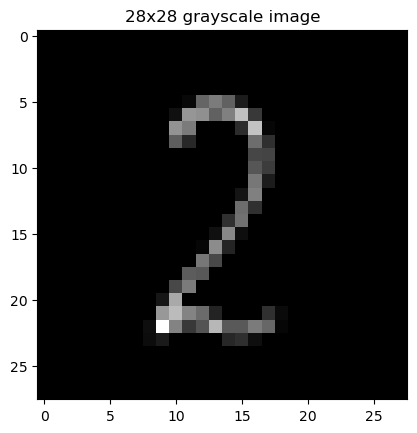

In [19]:
img_path = f"{dir_path}black_2.jpg"

img = Image.open(img_path)
img = img.convert('L').resize((28, 28))
plt.imshow(img, cmap='gray')
plt.title("28x28 grayscale image")
plt.show()

In [20]:
img_np = np.array(img)
img_np = img_np / 255.0
sample = img_np.reshape(1, -1) 

logits = model.forward(sample)
predicted_class = np.argmax(logits, axis=1)[0]

print(f"predicted digit: {predicted_class}")

predicted digit: 2


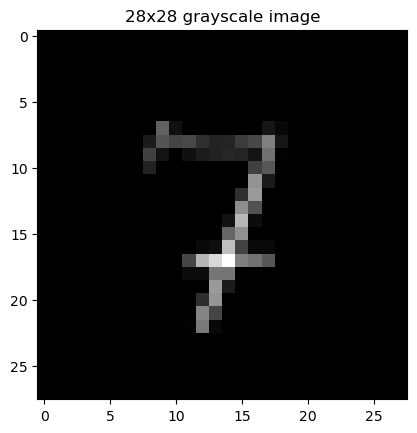

In [21]:
img_path = f"{dir_path}black_7.jpg"

img = Image.open(img_path)
img = img.convert('L').resize((28, 28))
plt.imshow(img, cmap='gray')
plt.title("28x28 grayscale image")
plt.show()

In [22]:
img_np = np.array(img)
img_np = img_np / 255.0
sample = img_np.reshape(1, -1) 

logits = model.forward(sample)
predicted_class = np.argmax(logits, axis=1)[0]

print(f"predicted digit: {predicted_class}")

predicted digit: 7
